# Exercise 2: Umbrella sampling

In this exercise, we will perform umbrella sampling simulations for the NaCl system and compute it free energy surface as a function of the ion-pair distance. As mentioned, umbrella sampling is composed of the following 3 steps that we will elaborate later:
- A pulling simulation (a.k.a steered MD) 
- Generation of the initial configuraitons for the production runs
- Production runs. 


This exercise should be done in an interactive session on Bridges-2, which 32 CPU cores requested. Note that here we are running the simulations in the NVT ensemble, which makes pulling more straightforward.

In [1]:
%%bash
# Here we remove the output of the exercise if there is any.
dirs=(sim_* pull *mdp *dat)
for dir in "${dirs[@]}"; do
    if ls -d "$dir" >/dev/null 2>&1; then
        rm -rf "$dir"
    fi
done

## 1. Pulling simulation

In [2]:
%%bash
mkdir pull

The purpose of a pulling simulation is to generate initial configurations with different CV values for the subsequent production simulations. In a pulling simulation, we need to divide the system of interest (NaCl) into two parts 

- The immobile group: The part of the system that is immobilized by a **position restraint**. In this exercise, we choose to fix the sodium ion, but choosing to fix the chloride ion should not make a difference in the resulting free energy profile. 

<center> 
➡️ This can be done by modifying the TOP file.
</center>

- The pull group: The part of the system we want to pull away from the immobile group using the **pull code**. Here, we choose the chloride ion as the pull group. 

<center> 
➡️ This can be done by modifying the MDP file.
</center>

## 1-1. Modification of the `top` file

In [3]:
%%bash
cat ../Inputs/NaCl/NaCl.top  # the original top file we used

#include "oplsaa.ff/forcefield.itp"
#include "oplsaa.ff/tip3p.itp"

[ moleculetype ]
; molname   nrexcl
CL      1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_401    1       CL          CL       1      -1       35.45300

[ moleculetype ]
; molname   nrexcl
NA          1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_407    1       NA          NA       1      1        22.98977

[ System ]
NaCl in water

[ Molecules ]
SOL         107
NA               1
CL               1


To make the topology aware of the position restraint, we need to add the following right after the `[ atoms ]` directive of NA.

In [4]:
%%bash 
echo '#include "oplsaa.ff/forcefield.itp"
#include "oplsaa.ff/tip3p.itp"

[ moleculetype ]
; molname   nrexcl
CL      1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_401    1       CL          CL       1      -1       35.45300

[ moleculetype ]
; molname   nrexcl
NA          1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_407    1       NA          NA       1      1        22.98977

; position restraints for Na
# ifdef POSRES_NA
# include "Na_posres.itp"
# endif

[ System ]
NaCl in water

[ Molecules ]
SOL         107
NA               1
CL               1' > pull/NaCl_US.top

```
; position restraints for Na
# ifdef POSRES_NA
# include "Na_posres.itp"
# endif
```

The added lines mean that **if the variable `POSRES_NA` is defined (in the `mdp` file), the position restraint defined in the file `Na_posres.itp` will be activated**. 

Clearly, now we don't have the file `Na_posres.itp`, so let's create one below.

In [5]:
%%bash 
cp ../Inputs/NaCl/NaCl.gro pull/.    # copy over the gro file by the way
echo '[ position_restraints ]
;  i funct       fcx        fcy        fcz
   1    1       1000       1000       1000' > pull/Na_posres.itp

Alternatively, you could run GROMACS `genrestr` command using `NaCl.gro`:
```
echo NA | mpirun -np 1 gmx_mpi genrestr -f pull/NaCl.gro -o pull/Na_posres.itp
```
In this case, the output `itp` file would require modification since the index would be 322 (the index of NA in `NaCl.gro`) instead of 1 (the index of NA in its own `[ moleculetype ]` directive, which is what we want).

## 1-2. Modification of the `mdp` file

In [6]:
%%bash
cat ../Inputs/NaCl/MD-NVT.mdp  # the original MDP file

integrator = md 
dt = 0.002
nsteps = 250000
cutoff-scheme = Verlet
coulombtype = PME
rlist = 0.6
rcoulomb = 0.6
rvdw = 0.6
constraints = h-bonds
tcoupl =  V-rescale
ref_t = 300
tau-t = 1.0
tc-grps = System
gen-vel = yes
gen-temp = 300
gen-seed = -1 
DispCorr = AllEnerPres
nstxout-compressed = 50
nstxout = 50000
nstvout = 50000


First, we need to define `POSRES_NA` at the top of the MDP file so the position restraint is activated. This is done by adding the following line at the top of the `mdp` file:
```
define=-DPOSRES_NA
```

In [7]:
%%bash
echo 'define=-DPOSRES_NA
integrator = md 
dt = 0.002
nsteps = 125000
cutoff-scheme = Verlet
coulombtype = PME
rlist = 0.6
rcoulomb = 0.6
rvdw = 0.6
constraints = h-bonds
tcoupl =  V-rescale
ref_t = 300
tau-t = 1.0
tc-grps = System
gen-vel = yes
gen-temp = 300
gen-seed = -1 
compressibility = 4.5e-5
nstxout-compressed = 50
nstxout = 50000
nstvout = 50000
' > pull/NaCl_pull.mdp
# Here we create an mdp file starting with `define=-DPOSRES_NA`

Then, to pull the chloride ion away, we need to use the pull code in the `mdp` file.

In [8]:
%%bash
echo '; Pull code
pull = yes
pull-ncoords = 1                  ; Here we only have 1 CV.
pull-ngroups = 2                  ; We have 2 groups (one immobile/reference group and one pull group).
pull-group1-name = NA             ; index 1
pull-group2-name = CL             ; index 2
pull-coord1-groups = 1 2          ; groups with indices 1 (NA) and 2 (CL) are involved
pull-coord1-type = umbrella       ; harmonic potential
pull-coord1-geometry = distance   ; simple distance increase
pull-coord1-dim = Y Y Y           ; We allow pulling from any directions.
pull-coord1-start = yes           ; We start the pulling with the initial ion-pair distance.
pull-coord1-rate = 0.0010         ; 0.0010 nm/ps -> the pull distance in the 250 ps-simulation is 0.25 nm.
pull-coord1-k = 1000              ; units: kJ/mol/nm^2' >> pull/NaCl_pull.mdp

Here are more explanations for some of the parameters:

- `pull_coord1_rate`: The rate at which the imaginary spring attached between the ions is elongated. Importantly, the pull distance must not 0.7428 nm, which is half of the smallest dimension of the box. This is to prevent the pull group from interacting with the periodic image of the system. Given that the typical ion-pair distance of NaCl is around 0.265 nm, a total pull distance of 0.3 nm should be safe.  
- `pull-coord1-k`: The force constant does not really matter as long as it is enough to pull the pull group away.

## 1-3. Running a pulling simulation

Now, we can finally run the pulling simulation. Notably, the `-r` option is necessary to be included for the restraint. 

In [9]:
%%time
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0
mpirun -np 1 gmx_mpi grompp -f pull/NaCl_pull.mdp -c pull/NaCl.gro -r pull/NaCl.gro -p pull/NaCl_US.top -o pull/pull.tpr -po pull/mdout.mdp -maxwarn 1

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -1243158286
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 5 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file pull/NaCl_pull.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.280 nm          0.280 nm
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 2 [file pull/NaCl_pull.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There were 2 notes

GROMACS reminds you: "Everybody's Good Enough For Some Change" (LIVE)



CPU times: user 37.7 ms, sys: 9.72 ms, total: 47.4 ms
Wall time: 741 ms


In [10]:
%%time
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0
mpirun -np 1 gmx_mpi mdrun -deffnm pull/pull -pf pull/pullf.xvg -px pull/pullx.xvg -ntomp 1

                  :-) GROMACS - gmx mdrun, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

CPU times: user 29.5 ms, sys: 5.94 ms, total: 35.5 ms
Wall time: 17.8 s


Compared to standard MD simulation, a pulling simulation has two additional output files: `pullf.xvg` and `pullf.xvg`, which document the timeseries of the pulling force and the ion-pair distance. 

## 2. Generation of the initial configurations

Given 32 CPUs available, we will divide the reaction path into 16 windows and run a simulation for each of them. The center of the window will range from the minimum ion-pair distance we got from the pulling simulation, to 0.6 nm, which is close enough to the upper bound of 0.7248 nm. For each window, we generate a configuration from the pulling simulation trajectory whose ion-pair distance is closet to the desired value (i.e., the center of the window). 

In [11]:
import numpy as np
pullx = np.transpose(np.loadtxt('pull/pullx.xvg', comments=['@', '#']))
t, dist = pullx[0], pullx[1]
centers = np.linspace(min(dist), 0.6, 8)  # the spacing between windows should be around 0.05 nm
diff_list = np.abs([dist - i for i in centers])
diff_idx = [np.argmin(diff_list[i]) for i in range(len(centers))]  # dist[diff_idx]: distances closet to the centers
t_extract = t[diff_idx]  # in ps
print(f'The initial configurations will be extracted from the following time frames (in ps): {t_extract}')
print(f'The ion-pair distances (in nm) of the chosen configurations are: {dist[diff_idx]}')

The initial configurations will be extracted from the following time frames (in ps): [  8.5 102.3 161.2 147.3 124.8 128.2 211.7 242.8]
The ion-pair distances (in nm) of the chosen configurations are: [0.251616 0.301441 0.351692 0.400633 0.450772 0.500438 0.550338 0.599096]


In [12]:
import os
for i in range(len(t_extract)):
    os.mkdir(f'sim_{i}')
    os.system(f'module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0 && echo System | mpirun -np 1 gmx_mpi trjconv -s pull/pull.tpr -f pull/pull.xtc -dump {t_extract[i]} -o sim_{i}/NaCl_{i}.gro')

                 :-) GROMACS - gmx trjconv, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


                 :-) GROMACS - gmx trjconv, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


                 :-) GROMACS - gmx trjconv, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


                 :-) GROMACS - gmx trjconv, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


                 :-) GROMACS - gmx trjconv, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


                 :-) GROMACS - gmx trjconv, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


                 :-) GROMACS - gmx trjconv, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


                 :-) GROMACS - gmx trjconv, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:


The cell above prepare the GRO files for the production runs. Now, we prepare the `mdp` file `NaCl_umbrella.mdp` that will be copied over to each simulation folder. Compared to the `mdp` file we used for the pulling simulation, `NaCl_umbrella.mdp` has the following 3 changes:
- The simulation lenght is 500 ps instead of 300 ps. 
- The pulling rate is set as 0.
- The force constant is set as 8000 instead of 1000 $\mathrm{kJ/mol/nm^2}$.

In [13]:
%%bash
cp pull/NaCl_pull.mdp NaCl_umbrella.mdp
sed -i -e "s/nsteps = 125000/nsteps = 250000/g" NaCl_umbrella.mdp  # simulation length: 500 ps for each umbrella
sed -i -e "s/pull-coord1-rate = 0.0010         ; 0.0010 nm\/ps -> the pull distance in the 250 ps-simulation is 0.25 nm./pull-coord1-rate = 0/g" NaCl_umbrella.mdp
sed -i -e "s/pull-coord1-k = 1000              ; units: kJ\/mol\/nm^2/pull-coord1-k = 8000/g" NaCl_umbrella.mdp
cat NaCl_umbrella.mdp

define=-DPOSRES_NA
integrator = md 
dt = 0.002
nsteps = 250000
cutoff-scheme = Verlet
coulombtype = PME
rlist = 0.6
rcoulomb = 0.6
rvdw = 0.6
constraints = h-bonds
tcoupl =  V-rescale
ref_t = 300
tau-t = 1.0
tc-grps = System
gen-vel = yes
gen-temp = 300
gen-seed = -1 
compressibility = 4.5e-5
nstxout-compressed = 50
nstxout = 50000
nstvout = 50000

; Pull code
pull = yes
pull-ncoords = 1                  ; Here we only have 1 CV.
pull-ngroups = 2                  ; We have 2 groups (one immobile/reference group and one pull group).
pull-group1-name = NA             ; index 1
pull-group2-name = CL             ; index 2
pull-coord1-groups = 1 2          ; groups with indices 1 (NA) and 2 (CL) are involved
pull-coord1-type = umbrella       ; harmonic potential
pull-coord1-geometry = distance   ; simple distance increase
pull-coord1-dim = Y Y Y           ; We allow pulling from any directions.
pull-coord1-start = yes           ; We start the pulling with the initial ion-pair distance.
pull

Now, we can generate a `tpr` file for each of the simulations. Here, we will use the same `top` file we used in the pulling simulation. 

In [14]:
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0

for i in {0..7}
do
    cp pull/NaCl_US.top sim_${i}/.    # Use the same top file as in the pulling simulation
    cp pull/Na_posres.itp sim_${i}/.  # Copy over the itp file for position restraint
    cp NaCl_umbrella.mdp sim_${i}/.   # All simulations use the same NaCl_umbrella.mdp
    cd sim_${i}
    mpirun -np 1 gmx_mpi grompp -f NaCl_umbrella.mdp -c NaCl_${i}.gro -r NaCl_${i}.gro -p NaCl_US.top -o NaCl_US.tpr -maxwarn 1  # Generate the tpr
    cd ../
done

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 368890732
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.251 nm          0.251 nm
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 2 [file NaCl_umbrella.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There were 2 notes


Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data



GROMACS reminds you: "Step Aside, Butch" (Pulp Fiction)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmuro

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 1780414873
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.302 nm          0.302 nm
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 2 [file NaCl_umbrella.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There were 2 notes

GROMACS reminds you: "I don't want to achieve immortality through my work... I want to achieve it through not dying!" (Woody Allen)

           

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 1764753564
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.351 nm          0.351 nm
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 2 [file NaCl_umbrella.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There were 2 notes

GROMACS reminds you: "If you're doing I/O, you're doing it wrong!" (Cannada "Drew" Lewis)

                 :-) GROMACS - gmx grompp, 2020.2-MOD

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 822796001
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.401 nm          0.401 nm
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 2 [file NaCl_umbrella.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There were 2 notes

GROMACS reminds you: "Nothing in biology makes sense except in the light of evolution." (Theodosius Dobzhansky)

                 :-) GROMACS - 

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 1410045457
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.450 nm          0.450 nm
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 2 [file NaCl_umbrella.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There were 2 notes

GROMACS reminds you: "I'm a strong believer that ignorance is important in science. If you know too much, you start seeing reasons why things wo

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -1514816984
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.500 nm          0.500 nm
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 2 [file NaCl_umbrella.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There were 2 notes

GROMACS reminds you: "Inventions have long since reached their limit, and I see no hope for further development." (Julius Sextus Frontinus, 1st 

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 494344564
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.550 nm          0.550 nm
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 2 [file NaCl_umbrella.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There were 2 notes

GROMACS reminds you: "Nurture Another Mind, Before Yours Expires" (Arrested Development)

                 :-) GROMACS - gmx grompp, 2020.2-MODI

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -73699167
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.599 nm          0.599 nm
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 2 [file NaCl_umbrella.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There were 2 notes

GROMACS reminds you: "I Need Love, Not Games" (Iggy Pop & Kate Pierson)



Then, we run the simulations of 8 windows in parallel using the `-multdir` flag as we did in the last exercise.

In [15]:
%%time
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0
mpirun -np 8 gmx_mpi mdrun -deffnm NaCl_US -pf pullf.xvg -px pullx.xvg -multidir sim_{0..7} -ntomp 4

                  :-) GROMACS - gmx mdrun, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

CPU times: user 85.6 ms, sys: 12.2 ms, total: 97.8 ms
Wall time: 33.5 s


Same as the pulling simulation, a `pullx.xvg` file (and a `pullf.xvg` file) will be generated in each of the simulation folders. To check the overlap between umbrella windows, we plot the histogram of the pulling distance for each simulation. 

In [16]:
import matplotlib.pyplot as plt
from matplotlib import rc

# Just some settings for plotting
rc('font', **{
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans'],
    'size': 10,
})
# Set the font used for MathJax - more on thiprint(images)
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')

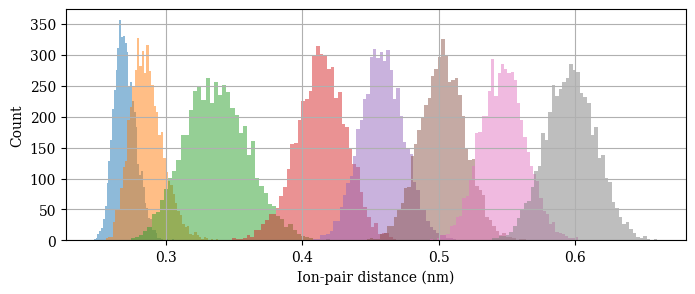

In [17]:
pullx_data = [np.transpose(np.loadtxt(f'sim_{i}/pullx.xvg', comments=['@', '#'])) for i in range(8)]
dist_list = [data[1] for data in pullx_data]

plt.figure(figsize=(8, 3))
for i in range(8):
    plt.hist(dist_list[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

As shown above, there is always overlap between neighboring windows, indicating that a force constant of 8000 $\mathrm{kJ/mol/nm^2}$ is reasonable. 
- If the force constant were too large, the spread of each distribution would have been too narrow, so there would be a risk of not having overlap between some of the neighboring replicas. 
- If the force constant were too small, it would be hard to keep the pull group at the desired center of the window. In this case, the pull group will drift to the metastable state, which could also lead to insufficient overlap. 

To futhur improve the overlap, one can
- Put 1 to 2 more windows between 0.3 to 0.4 nm (and stick with $k=8000 \text{ } \mathrm{kJ/mol/nm^2}$).
- Without increasing the number of windows, increase the force constants for the second and third windows.

## 3. Computation of the free energy surface using MBAR

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


Statistical inefficiency of simulation 0: 3.856
Statistical inefficiency of simulation 1: 1.605
Statistical inefficiency of simulation 2: 10.043
Statistical inefficiency of simulation 3: 6.045
Statistical inefficiency of simulation 4: 2.496
Statistical inefficiency of simulation 5: 3.674
Statistical inefficiency of simulation 6: 2.668
Statistical inefficiency of simulation 7: 5.757


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)



Time elapsed: 1 seconds.


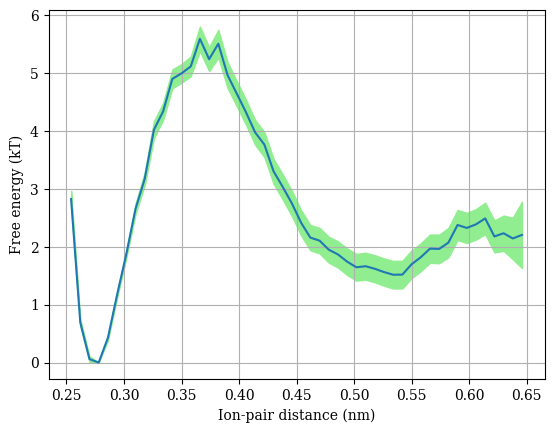

In [18]:
import time
import pymbar
from pymbar import timeseries
import random
import scipy.stats

t0 = time.time()

# Step 1: Setting up
K = 8                                       # number of umbrellas
N_max = 5001                                # number of data points in each timeseries of ion-pair distance
kT = 1.381e-23 * 6.022e23 / 1000 * 300      # 1 kT converted to kJ/mol at 300 K
beta_k = np.ones(K) / kT                    # inverse temperature of simulations (in 1/(kJ/mol)) 
d_min, d_max = 0.25, 0.65                   # minimum and maximum of the CV for plotting the FES
nbins = 50                                  # number of bins for FES
K_k = np.ones(K) * 8000                     # spring constant (in kJ/mol/nm**2) for different simulations
RunBootstrapping = False                    # Whether to perform bootstrapping to estimate the uncertainty of the FES
nboot = 50                                  # number of bootstrap samples (values from 50 to 200 are recommended)
N_k, g_k = np.zeros(K, int), np.zeros(K)    # number of samples and statistical inefficiency of different simulations
d_kn = np.zeros([K, N_max])                 # d_kn[k,n] is the ion-pair distance (in nm) for snapshot n from umbrella simulation k
u_kn = np.zeros([K, N_max])                 # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
uncorrelated_samples = []                   # Uncorrelated samples of different simulations

# Step 2: Read in and subsample the timeseries
for k in range(K):
    d_kn[k] = np.transpose(np.loadtxt(f'sim_{k}/pullx.xvg', comments=['@', '#']))[1]
    N_k[k] = len(d_kn[k])
    d_temp = d_kn[k, 0:N_k[k]]
    g_k[k] = timeseries.statistical_inefficiency(d_temp)     
    print(f"Statistical inefficiency of simulation {k}: {g_k[k]:.3f}")
    indices = timeseries.subsample_correlated_data(d_temp, g=g_k[k]) # indices of the uncorrelated samples
    
    # Update u_kn and d_kn with uncorrelated samples
    N_k[k] = len(indices)    # At this point, N_k contains the number of uncorrelated samples for each state k                
    u_kn[k, 0:N_k[k]] = u_kn[k, indices]
    d_kn[k, 0:N_k[k]] = d_kn[k, indices]
    uncorrelated_samples.append(d_kn[k, indices])

d0_k = np.array([d_kn[i][0] for i in range(K)])    
N_max = np.max(N_k) # shorten the array size
u_kln = np.zeros([K, K, N_max]) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella l
u_kn -= u_kn.min()  # shift the minimum of the FES to 0

# Step 3: Bin the data
bin_center_i = np.zeros([nbins])
bin_edges = np.linspace(d_min, d_max, nbins + 1)
for i in range(nbins):
    bin_center_i[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])
   
# Step 4: Evaluate reduced energies in all umbrellas
for k in range(K):
    for n in range(N_k[k]):
        # Compute minimum-image ion-pair distance deviation from umbrella center l
        dd = d_kn[k,n] - d0_k  # delta d

        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k,:,n] = u_kn[k,n] + beta_k[k] * (K_k / 2) * dd ** 2

# Step 5: Compute, output, and plot the FES
fes = pymbar.FES(u_kln, N_k, verbose=False)
histo_params = {'bin_edges': bin_edges}
d_n = pymbar.utils.kn_to_n(d_kn, N_k=N_k)
fes.generate_fes(u_kn, d_n, fes_type='histogram', histogram_parameters=histo_params)
results = fes.get_fes(bin_center_i, reference_point="from-lowest", uncertainty_method="analytical")
f_i = results["f_i"]
df_i = results["df_i"]

with open('fes.dat', 'w') as f:
    f.write("# free energy profile (in units of kT), from histogramming\n")
    f.write(f"# {'bin':>8s} {'f':>8s} {'df':>8s} \n")
    for i in range(nbins):
       f.write(f"{bin_center_i[i]:>8.3f} {f_i[i]:>8.3f} {df_i[i]:>8.3f} \n")

plt.figure()
plt.plot(bin_center_i, f_i)
plt.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Free energy (kT)')
plt.grid()

t1 = time.time()
print(f'\nTime elapsed: {t1 - t0:.0f} seconds.')

As can be checked below, regions with more uncorrelated samples generally have smaller a uncertainty in the free energy profile. 

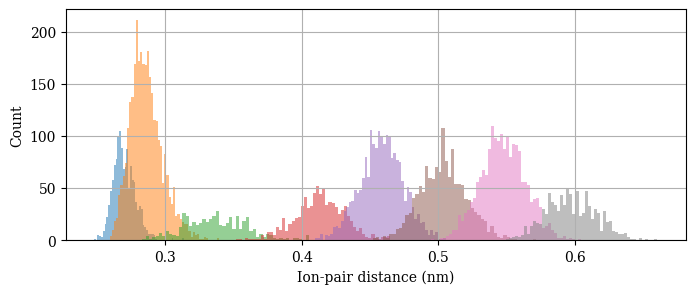

In [19]:
plt.figure(figsize=(8, 3))
for i in range(8):
    plt.hist(uncorrelated_samples[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

## 4. Reference(s)
- A review about umbrella sampling: [Kästner, Johannes. "Umbrella sampling." Wiley Interdisciplinary Reviews: Computational Molecular Science 1.6 (2011): 932-942.](https://doi.org/10.1002/wcms.66)